In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pickle as pickle
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.parametric_coupling as pmc
import analysis.plotting as plotting
import analysis.analysis as analysis

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

Qubit(RO_IF=None, qubit_id=q1, RO_LO_45=6.3804, RO_LO=6.6247, ROIF=0.10264000000000006, ro_dur=5000, ro_freq=6.72734, ef_half_time=25, mixer_offset_ef=6, ef_time=46, mixer_offset_ge=2.5, ef_ssm=-0.259, ef_amp=1.5, ef_half_amp=1.3, ge_amp=1, ro_amp=0.25, IQ_angle=60, RO_LO_34=6.4804, RO_LO_pwr=16, qubit_thr=[-10000, -600], ge_time=77, ge_ssm=-0.117)
Qubit(RO_IF=None, qubit_id=q2, RO_LO_45=6.3804, RO_LO=6.6247, ROIF=0.030700000000000394, ro_dur=5000, ro_freq=6.6554, ef_half_time=None, mixer_offset_ef=None, ef_time=None, mixer_offset_ge=2.5, ef_ssm=-0.2962, ef_amp=1, ef_half_amp=None, ge_amp=1, ro_amp=0.6, IQ_angle=25, RO_LO_34=6.4804, RO_LO_pwr=16, qubit_thr=[-10000, 1900], ge_time=62, ge_ssm=-0.155)


In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_amp"],
    bnc_addr= bnc_address["TWPA_address"],
)

In [4]:
def swap_gate_sweep(freq_list,spec_amp,num_steps, reps, sweep_time, filename="swap_gate_sweep.pkl"):
    """
    Run a swap gate sweep by performing parametric coupling experiments at each frequency.
    Save results to a file after each step. If the file already exists, restart from the last completed step.
    """
     # Number of time steps for the parametric coupling experiment

    # Initialize arrays to store results
    I1_data = np.zeros((len(freq_list), num_steps))
    Q1_data = np.zeros((len(freq_list), num_steps))
    I2_data = np.zeros((len(freq_list), num_steps))
    Q2_data = np.zeros((len(freq_list), num_steps))

    # Check if the file exists
    if os.path.exists(filename):
        print(f"Loading existing data from {filename}...")
        with open(filename, "rb") as f:
            saved_data = pickle.load(f)

        # Load saved data
        I1_data = saved_data["I1_data"]
        Q1_data = saved_data["Q1_data"]
        I2_data = saved_data["I2_data"]
        Q2_data = saved_data["Q2_data"]
        last_completed_step = saved_data["last_completed_step"]

        print(f"Resuming from step {last_completed_step + 1}/{len(freq_list)}")
    else:
        last_completed_step = -1  # Start from the beginning

    # Run the sweep
    for i in range(last_completed_step + 1, len(freq_list)):
        frequency = freq_list[i]

        # Perform parametric coupling experiment
        pmc.parametric_coupling_time_domain(
            q1,
            q2,
            general_vals_dict,
            num_steps=num_steps,
            ssm_para=frequency,
            spec_amp=spec_amp,
            sweep_time=sweep_time,
            phase=0,
            verbose=False,
        )
        wx.wx_set_and_amplitude_and_offset(
            amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
        )
        # Acquire the raw IQ data
        values = daq.run_daq_het_2q(
            q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
        )

        # Retrieve raw IQ data from the acquired values
        # I1_raw = values.rec_readout_1[0][:reps * num_steps]
        # Q1_raw = values.rec_readout_1[1][:reps * num_steps]
        # I2_raw = values.rec_readout_2[0][:reps * num_steps]
        # Q2_raw = values.rec_readout_2[1][:reps * num_steps]
        I1_raw = values.rec_avg_vs_pats_1[0]
        Q1_raw = values.rec_avg_vs_pats_1[1]
        I2_raw = values.rec_avg_vs_pats_2[0]
        Q2_raw = values.rec_avg_vs_pats_2[1]

        # Store results
        I1_data[i] = I1_raw
        Q1_data[i] = Q1_raw
        I2_data[i] = I2_raw
        Q2_data[i] = Q2_raw

        # Save results to file after each step
        with open(filename, "wb") as f:
            pickle.dump(
                {
                    "freq_list": freq_list,
                    "I1_data": I1_data,
                    "Q1_data": Q1_data,
                    "I2_data": I2_data,
                    "Q2_data": Q2_data,
                    "last_completed_step": i,  # Track the last completed step
                },
                f,
            )

        print(f"------------- Done with {i+1}/{len(freq_list)} --------------------")

    return I1_data, Q1_data, I2_data, Q2_data

In [ ]:
freq_center =  -0.020
delta = 0.005

spec_amp=1.5
num_steps=101
freq_list = np.linspace(freq_center - delta, freq_center + delta, 11 )
sweep_time = 500
reps=500
I1_data, Q1_data, I2_data, Q2_data=swap_gate_sweep(freq_list,spec_amp,num_steps, reps, sweep_time, filename="swap_gate_sweep.pkl")

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 500
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 11.167132 sec
Captured 17 buffers (1.522325 buffers per sec)
Captured 52224 records (4676.581180 records per sec)
Transferred 855638016 bytes (76621106.057839 bytes per sec)
------------- Done with 1/11 --------------------
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ri

In [15]:
# Check if the file exists
filename = "swap_gate_sweep.pkl"
if os.path.exists(filename):
    print(f"Loading existing data from {filename}")
    with open(filename, "rb") as f:
        saved_data = pickle.load(f)

    # Load saved data
    I1_data = saved_data["I1_data"]
    Q1_data = saved_data["Q1_data"]
    I2_data = saved_data["I2_data"]
    Q2_data = saved_data["Q2_data"]
    freq_list = saved_data["freq_list"]
    last_completed_step = saved_data["last_completed_step"]

Loading existing data from swap_gate_sweep.pkl


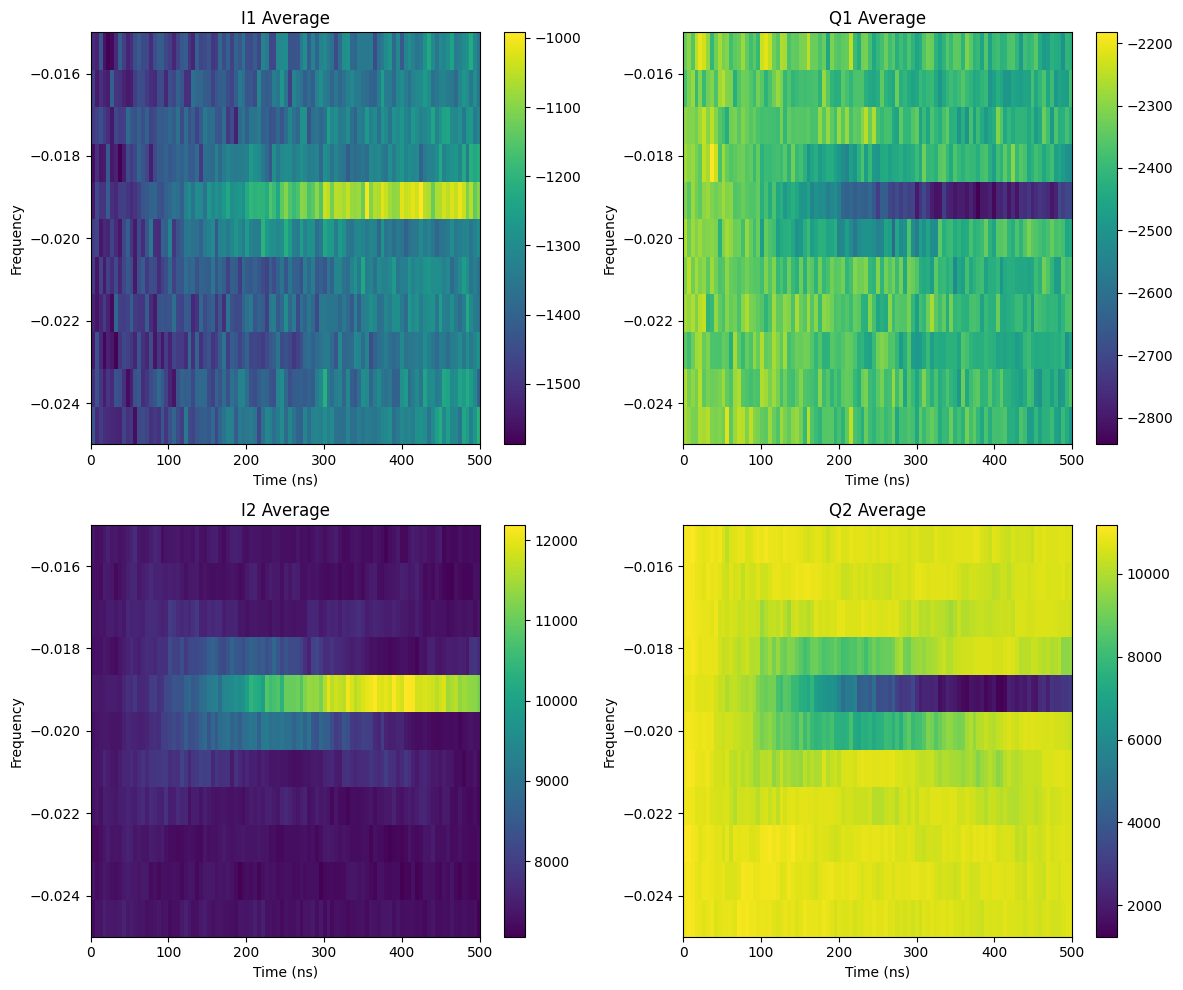

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot I1_data
im1 = axes[0, 0].imshow(
    I1_data,
    aspect="auto",
    extent=[0, sweep_time, freq_list[0], freq_list[-1]],
    origin="lower",
)
axes[0, 0].set_title("I1 Average")
axes[0, 0].set_xlabel("Time (ns)")
axes[0, 0].set_ylabel("Frequency")
fig.colorbar(im1, ax=axes[0, 0])

# Plot Q1_data
im2 = axes[0, 1].imshow(
    Q1_data,
    aspect="auto",
    extent=[0, sweep_time, freq_list[0], freq_list[-1]],
    origin="lower",
)
axes[0, 1].set_title("Q1 Average")
axes[0, 1].set_xlabel("Time (ns)")
axes[0, 1].set_ylabel("Frequency")
fig.colorbar(im2, ax=axes[0, 1])

# Plot I2_data
im3 = axes[1, 0].imshow(
    I2_data,
    aspect="auto",
    extent=[0, sweep_time, freq_list[0], freq_list[-1]],
    origin="lower",
)
axes[1, 0].set_title("I2 Average")
axes[1, 0].set_xlabel("Time (ns)")
axes[1, 0].set_ylabel("Frequency")
fig.colorbar(im3, ax=axes[1, 0])

# Plot Q2_data
im4 = axes[1, 1].imshow(
    Q2_data,
    aspect="auto",
    extent=[0, sweep_time, freq_list[0], freq_list[-1]],
    origin="lower",
)
axes[1, 1].set_title("Q2 Average")
axes[1, 1].set_xlabel("Time (ns)")
axes[1, 1].set_ylabel("Frequency")
fig.colorbar(im4, ax=axes[1, 1])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

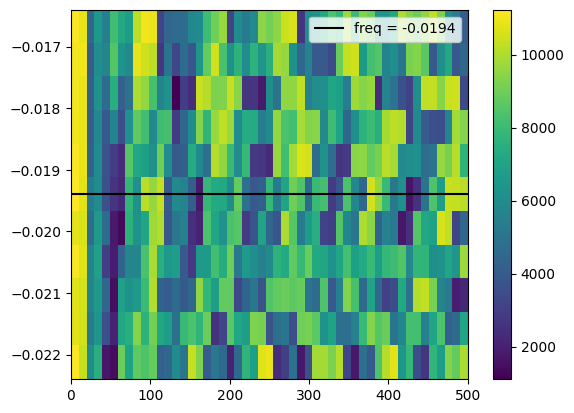

In [9]:
max_index_I2_data = np.unravel_index(np.argmax(Q2_data), Q2_data.shape)
plt.imshow(
    Q2_data,
    aspect="auto",
    extent=[0, sweep_time, freq_list[0], freq_list[-1]],
    origin="lower",
)
plt.axhline(
    y=freq_list[max_index_I2_data[0]],
    color="black",
    label=f"freq = {freq_list[max_index_I2_data[0]]:.4f}",
)
plt.legend()
plt.colorbar()
plt.show()

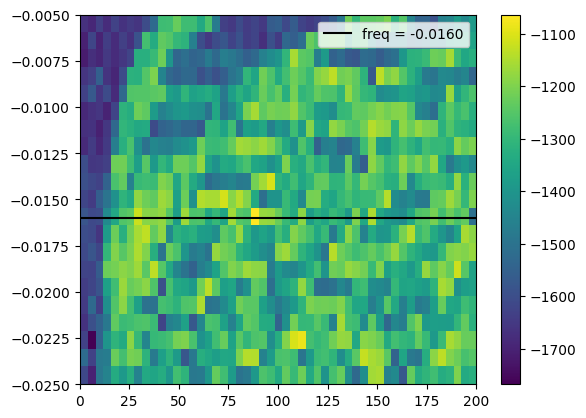

In [ ]:
max_index_I1_data = np.unravel_index(np.argmax(I1_data), Q1_data.shape)
plt.imshow(
    I1_data,
    aspect="auto",
    extent=[0, sweep_time, freq_list[0], freq_list[-1]],
    origin="lower",
)
plt.axhline(
    y=freq_list[max_index_I1_data[0]],
    color="black",
    label=f"freq = {freq_list[max_index_I1_data[0]]:.4f}",
)
plt.legend()
plt.colorbar()
plt.show()

In [ ]:
# num_steps = 101
# reps = 2000
# frequency = -0.0194
# sweep_time = 400  # 0.5*num_steps/abs(frequency)#7#500
# phase = 0
# spec_amp = 1.4
# pmc.parametric_coupling_time_domain(
#     q1,
#     q2,
#     general_vals_dict,
#     num_steps=num_steps,
#     ssm_para=frequency,
#     spec_amp=spec_amp,
#     sweep_time=sweep_time,
#     phase=phase,
#     verbose=False,
# )
# wx.wx_set_and_amplitude_and_offset(
#     amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
# )
# # Acquire the raw IQ data
# values = daq.run_daq_het_2q(
#     q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
# )
# print(0.5 * 1 / abs(frequency))

In [ ]:
times = np.linspace(0, sweep_time / 1000, num_steps)  # x-axis values in milliseconds
IQ_df = plotting.get_IQ_averages(values)
# Create the 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot I1
axes[0, 0].plot(times, IQ_df["I1"], color="blue", label="I1")
axes[0, 0].set_title("I1 vs Time")
axes[0, 0].set_xlabel("Time (ms)")
axes[0, 0].set_ylabel("Amplitude")
# axes[0,0].set_xlim([0,5])
axes[0, 0].grid(True)
axes[0, 0].legend()
axes[0, 0].axvline(330 / 1000)

# Plot Q1
axes[0, 1].plot(times, IQ_df["Q1"], color="red", label="Q1")
axes[0, 1].set_title("Q1 vs Time")
axes[0, 1].set_xlabel("Time (ms)")
axes[0, 1].set_ylabel("Amplitude")
# axes[0,1].set_xlim([0,5])
axes[0, 1].grid(True)
axes[0, 1].legend()

# Plot I2
axes[1, 0].plot(times, IQ_df["I2"], color="green", label="I2")
axes[1, 0].set_title("I2 vs Time")
axes[1, 0].set_xlabel("Time (ms)")
axes[1, 0].set_ylabel("Amplitude")
axes[1, 0].grid(True)
# axes[1,0].set_xlim([0,5])
axes[1, 0].legend()
# axes[1, 0].axvline(310/1000)

# Plot Q2
axes[1, 1].plot(times, IQ_df["Q2"], color="purple", label="Q2")
axes[1, 1].set_title("Q2 vs Time")
axes[1, 1].set_xlabel("Time (ms)")
axes[1, 1].set_ylabel("Amplitude")
# axes[1,1].set_xlim([0,5])
axes[1, 1].grid(True)
axes[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

NameError: name 'values' is not defined

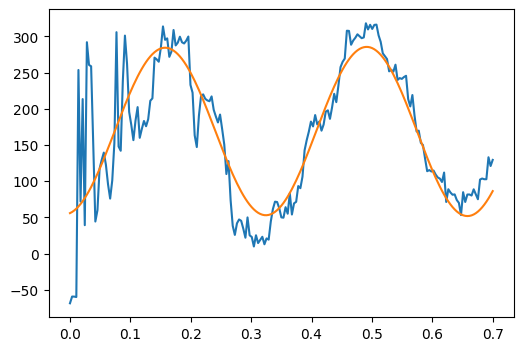



  freq: 2.9960453953494794 +/- 0.036489954130336365
 gamma: -0.02945427899411611 +/- 0.20056741675837947
   amp: -114.87090785390657 +/- 9.688439287842684
 phase: 100.19710434092654 +/- 5.071319920205801
offset: 168.8594145068977 +/- 3.628825928967609
pi_pulse time: 0.1668866569165173 +/- 0.036489954130336365
π_ge time = 166.8866569165173 ns


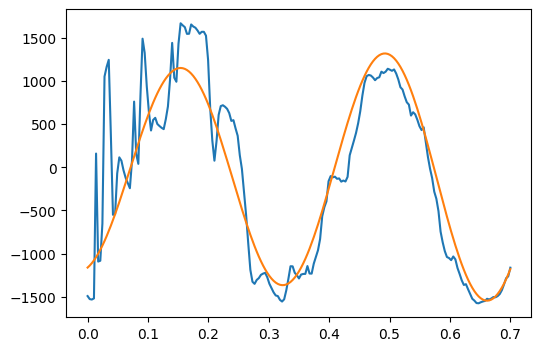



  freq: 2.955047857721654 +/- 0.028389614564371814
 gamma: -0.38259421960784695 +/- 0.15915767572292558
   amp: -1149.2813171517125 +/- 81.83150313382104
 phase: 107.49628031860976 +/- 4.140782184658382
offset: -65.78379461520528 +/- 32.374273921902414
pi_pulse time: 0.16920199742061054 +/- 0.028389614564371814
π_ge time = 169.20199742061055 ns


In [ ]:
IQ_df = plotting.get_IQ_averages(values)
I1 = IQ_df["I1"]
I2 = IQ_df["I2"]
Q1 = IQ_df["Q1"]
Q2 = IQ_df["Q2"]

Qrange1 = abs(np.max(Q1) - np.min(Q1))
Irange1 = abs(np.max(I1) - np.min(I1))
if Qrange1 > Irange1:
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, Q1, guess_vals=[5, 2, np.abs(np.max(Q1) - np.min(Q1)), 38, Q1[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, I1, guess_vals=[5, 2, np.abs(np.max(I1) - np.min(I1)), 38, I1[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
Qrange2 = abs(np.max(Q2) - np.min(Q2))
Irange2 = abs(np.max(I2) - np.min(I2))
if Qrange2 > Irange2:
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, Q2, guess_vals=[5, 2, np.abs(np.max(Q2) - np.min(Q2)), 38, Q1[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, I2, guess_vals=[5, 2, np.abs(np.max(I2) - np.min(I2)), 38, I1[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))

In [ ]:
frequency = -0.0194
time_fixed = 150#7 * 0.5 * 1 / abs(frequency)
amp_start = 1.3
amp_stop = 1.5
amp_steps = 21
num_steps = 3
reps = 15000
phase = 0
I1 = np.zeros(amp_steps)
I2 = np.zeros(amp_steps)
amp = np.linspace(amp_start, amp_stop, amp_steps)
for i in range(len(amp)):
    spec_amp = amp[i]
    pmc.parametric_coupling_time_domain(
        q1,
        q2,
        general_vals_dict,
        num_steps=num_steps,
        ssm_para=frequency,
        spec_amp=spec_amp,
        sweep_time=time_fixed,
        phase=phase,
        verbose=False,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )
    IQ_df = plotting.get_IQ_averages(values)
    I1[i] = IQ_df["I1"][2]
    I2[i] = IQ_df["Q2"][2]

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.204
0, No error
10.225.208.204
0, No error
0, No error
10.225.208.204
0, No error
10.225.208.204
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 5.242675 sec
Captured 15 buffers (2.861135 buffers per sec)
Captured 46080 records (8789.405661 records per sec)
Transferred 754974720 bytes (144005622.351727 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
lo

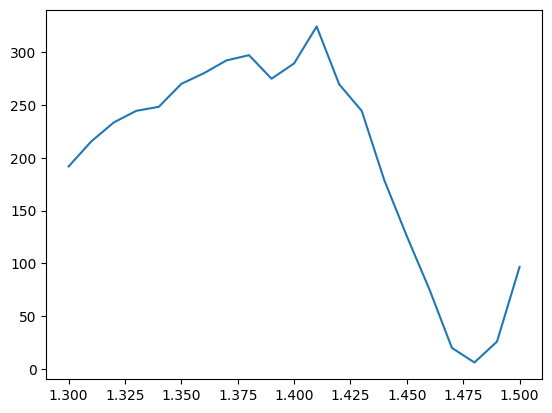

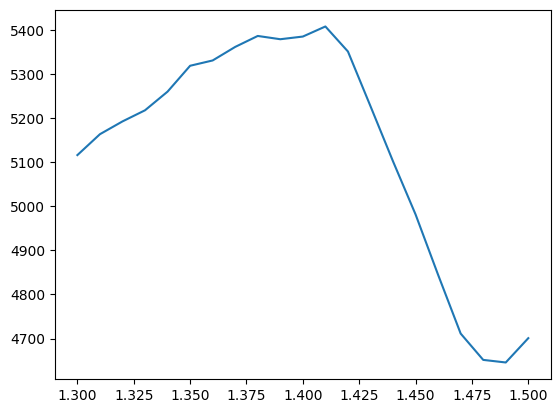

1.4100000000000001


In [ ]:
plt.plot(amp, I1)
plt.show()
plt.plot(amp, I2)
plt.show()
max_index_I2 = np.unravel_index(np.argmax(I2), I2.shape)
print(amp[max_index_I2[0]])